In [1]:
%matplotlib inline
import torch
from matplotlib import pyplot as plt
import random

# Linear Regression from Scratch

* This notebook shows how linear regression can be implemented (almost) from scratch. This will involve:
    * Creating a dataset.
    * Defining a linear regression model.
    * Initializing the model parameters (weights and bias).
    * Defining a loss function.
    * Implementing an optimization algorithm (minibatch stochastic gradient descent).
    * Executing the training loop:
        * Computing the gradient of the loss with respect to the parameters (using automatic differentiation).
        * Updating the parameters based on this gradient.

* PyTorch already implements many of these steps, as the next notebook will show.

# Creating the Dataset

* We will create a simple dataset to serve as an example.
* Our goal will be to find the parameters that we used to create this dataset, as if we did not know them.
* The training dataset $(\mathbf{x}^{(1)}, y^{(1)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})$ is composed of $n = 1000$ examples.
* Each observation $\mathbf{x}^{(i)}$ is a $2$-dimensional vector whose features are sampled from a standard normal distribution.
* We will use a design matrix $\mathbf{X}$ to represent the observations (without an extra column filled with ones).
* The target vector $\mathbf{y} = [y^{(1)}, \ldots, y^{(n)}]^T$ will be given by

$$ \mathbf{y} = \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}, $$

where $\mathbf{w} = [2, -3.4]^T$ and $b = 4.2$ are the true model parameters, and $\boldsymbol{\epsilon}$ is an $n$-dimensional *noise* vector whose elements are sampled from a normal distribution with standard deviation $0.01$

* If the noise vector $\boldsymbol{\epsilon}$ were zero, we would only need three examples to find the true parameters.

In [2]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.mm(X, w) + b
    y += torch.normal(0, 0.01, y.size())
    return X, y

In [14]:
true_w = torch.tensor([[2], [-3.4]])
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.size())
print(labels.size())

torch.Size([1000, 2])
torch.Size([1000, 1])


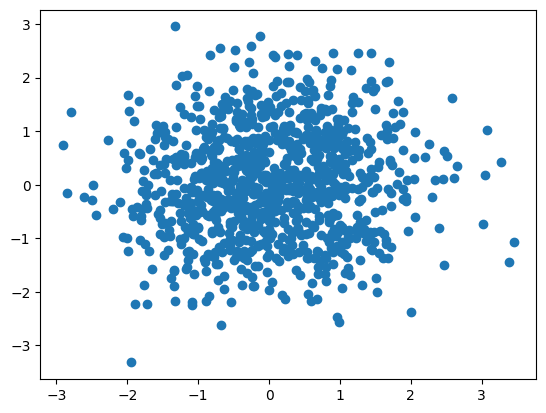

In [4]:
# Scatter plot of the observations
plt.scatter(features[:, 0], features[:, 1]);

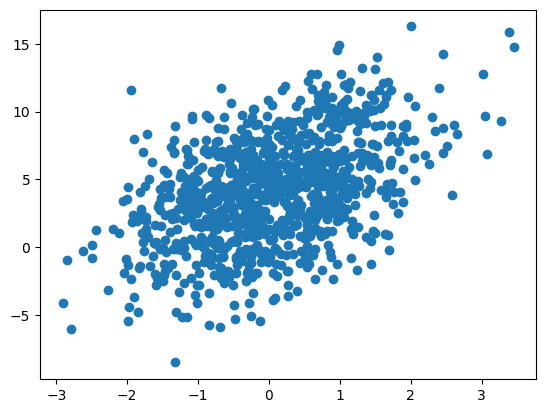

In [5]:
# Scatter plot of the first features against the targets. Note the positive correlation.
plt.scatter(features[:, 0], labels);

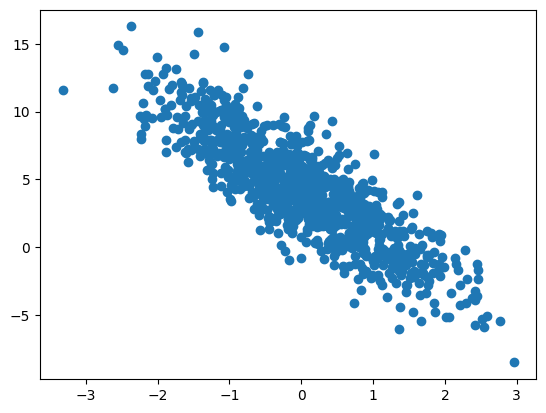

In [6]:
# Scatter plot of the second features against the targets. Note the negative correlation.
plt.scatter(features[:, 1], labels);

# Generating batches

* In order to implement minibatch stochastic gradient descent, we need to generate batches of examples.

* In Python, this can be accomplished using a [generator](https://docs.python.org/3/tutorial/classes.html#generators).

* The generator `data_iter` defined below `yields` a minibatch (a pair of features/labels) each time it is asked for a next element. After the first element is requested, recall that `data_iter` will resume from `yield`.

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The order of examples is randomized once
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

# Shows first minibatch
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(f'Features:\n {X}')
    print(f'Labels:\n {y}')
    break

Features:
 tensor([[-2.0636, -0.9750],
        [-1.4682, -0.7159],
        [ 0.4561,  0.5953],
        [-0.1997,  0.3594],
        [-0.5797,  1.4050],
        [-0.6102, -0.4021],
        [-0.1985,  0.7836],
        [ 0.3694, -0.3172],
        [-0.4626,  1.1817],
        [ 1.1429, -1.6776]])
Labels:
 tensor([[ 3.3835],
        [ 3.6897],
        [ 3.0818],
        [ 2.5736],
        [-1.7425],
        [ 4.3405],
        [ 1.1258],
        [ 6.0209],
        [-0.7439],
        [12.1844]])


* PyTorch implements its own highly efficient data iterators that are also able to deal with datasets stored in files.

# Defining the Model

* Recall that linear regression supposes that the target vector $\mathbf{y}$ is given by $\mathbf{y} = \mathbf{X} \mathbf{w} + b$

* Recall that broadcasting can be used to add the bias $b$ to each element of the vector $\mathbf{X}\mathbf{w}$.

In [8]:
def linreg(X, w, b):
    """The linear regression model: y = Xw + b
       X: [num_of_examples, num_of_feat]
       w: [num_of_feat, 1]
       b: scalar
       y: [num_of_examples, 1]"""
    return torch.mm(X, w) + b

# Initializing Model Parameters

* Minibatch stochastic gradient descent requires that the parameters are initialized.

* Since the parameters can be initialized arbitrarily, we will sample each element of the weights from a normal distribution with standard deviation $0.01$. We will initialize the bias to zero.

* Note that we request PyTorch to keep track of gradients with respect to `w` and `b`.

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Defining the Loss Function

* We can define the squared loss function as follows.


In [10]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return torch.mean((y_hat - y) ** 2 / 2)

# Defining the Optimization Algorithm

* Although the linear regression problem has an analytic solution, minibatch stochastic gradient descent will also be used for neural networks.

* The following code applies the minibatch stochastic gradient descent update given a set of parameters, a learning rate, and a batch size.

* Note that we do not wish to track gradients of the update operation.

In [11]:
def sgd(params, lr):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

# Training Loop
* During each **epoch**:
    * Execute one iteration per minibatch.
    * During each iteration:
        * Obtain the minibatch.
        * Compute predictions and loss using the current model (**forward pass**).
        * Compute the gradients of the loss with respect to model parameters (**backward pass**).
        * Update the model parameters.

In [12]:
# Hyperparameters
num_epochs = 3
lr = 0.5

print('\nInitial parameters:')
print(w)
print(b)

print()

# Training loop
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # Minibatch: `X` and `y`
        y_hat = linreg(X, w, b) # Prediction for the minibatch
        l = squared_loss(y_hat, y)  # Loss for the minibatch
        l.backward() # Compute gradient of `l` with respect to [`w`, `b`]
        sgd([w, b], lr)  # Update parameters using this gradient

    # After each epoch, computes the loss for the entire training dataset
    with torch.no_grad():
        train_l = squared_loss(linreg(features, w, b), labels)
        print(f'Epoch: {epoch + 1}. Loss: {float(train_l):f}')

print('\nLearned parameters:')
print(w)
print(b)

print('\nTrue parameters:')
print(true_w)
print(true_b)


Initial parameters:
tensor([[-0.0074],
        [ 0.0161]], requires_grad=True)
tensor([0.], requires_grad=True)

Epoch: 1. Loss: 0.000060
Epoch: 2. Loss: 0.000061
Epoch: 3. Loss: 0.000052

Learned parameters:
tensor([[ 1.9997],
        [-3.3993]], requires_grad=True)
tensor([4.1980], requires_grad=True)

True parameters:
tensor([[ 2.0000],
        [-3.4000]])
tensor(4.2000)


# Evaluation

* Because we created the dataset, we can evaluate our success by comparing the true parameters with the learned parameters.


# [Storing this notebook as a `pdf`]

In [13]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Set the path to this notebook below (add \ before spaces). The output `pdf` will be stored in the corresponding folder.
!jupyter nbconvert --to pdf /content/gdrive/My\ Drive/Colab\ Notebooks/nndl/week_03/lecture/02_Linear_Regression_from_Scratch.ipynb

# If having issues, save this notebook (File > Save) and restart the session (Runtime > Restart session) before running this cell. To debug, remove the first line (`%%capture`).